## Import Libraries

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df


Reading csv from 

Mem. usage decreased to  3.24 Mb (48.4% reduction)


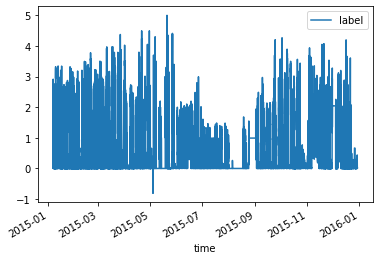

In [ ]:
data = pd.read_excel('https://github.com/cruveilc/Occupancy-Forecasting/blob/main/output.xlsx?raw=true',
sheet_name=0,
header=0,
index_col=[0],
keep_default_na=True
).pipe(reduce_mem_usage, verbose=True)

#data = data[data.index.dayofweek < 5]
#data = data.between_time('06:00','23:00')

data = data[['label']]
split_date = '05-May-2015'
data.plot()

time = data.index

Creating Multistep parameters

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('label%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('label%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('label%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = time
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
     
    return agg

Scaling

In [ ]:
data2=data[['label']]

#print(data.iloc[:,0])
#labelEncoder = LabelEncoder()
#data.iloc[:,0] = labelEncoder.fit_transform(data.iloc[:,0])
values = data2.values
print(values.shape)
values = values.astype('float32')

(102930, 1)


In [ ]:
print(values[0])

[1.128]


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(values,12*24,12*24)



reframed

,label1(t-288),label1(t-287),label1(t-286),label1(t-285),label1(t-284),label1(t-283),label1(t-282),label1(t-281),label1(t-280),label1(t-279),label1(t-278),label1(t-277),label1(t-276),label1(t-275),label1(t-274),label1(t-273),label1(t-272),label1(t-271),label1(t-270),label1(t-269),label1(t-268),label1(t-267),label1(t-266),label1(t-265),label1(t-264),label1(t-263),label1(t-262),label1(t-261),label1(t-260),label1(t-259),label1(t-258),label1(t-257),label1(t-256),label1(t-255),label1(t-254),label1(t-253),label1(t-252),label1(t-251),label1(t-250),label1(t-249),...,label1(t+248),label1(t+249),label1(t+250),label1(t+251),label1(t+252),label1(t+253),label1(t+254),label1(t+255),label1(t+256),label1(t+257),label1(t+258),label1(t+259),label1(t+260),label1(t+261),label1(t+262),label1(t+263),label1(t+264),label1(t+265),label1(t+266),label1(t+267),label1(t+268),label1(t+269),label1(t+270),label1(t+271),label1(t+272),label1(t+273),label1(t+274),label1(t+275),label1(t+276),label1(t+277),label1(t+278),label1(t+279),label1(t+280),label1(t+281),label1(t+282),label1(t+283),label1(t+284),label1(t+285),label1(t+286),label1(t+287)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-07 15:00:00,1.128000,0.622000,0.634000,0.285733,0.094,0.062,0.006,0.086,0.090,0.000000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532,2.390000,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,...,2.400440,2.430907,1.408853,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298,1.804000,1.844000,1.794000,1.804000,2.340907,1.80400,1.83200,1.91200,1.80336,1.54800,1.72200,1.72200,1.76336,0.548,0.086,0.086,0.006,0.006,0.006,0.00,0.080000,0.000000
2015-01-07 15:05:00,0.622000,0.634000,0.285733,0.094000,0.062,0.006,0.086,0.090,0.000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,...,2.430907,1.408853,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298000,1.804,1.844000,1.794000,1.804000,2.340907,1.804000,1.83200,1.91200,1.80336,1.54800,1.72200,1.72200,1.76336,0.54800,0.086,0.086,0.006,0.006,0.006,0.000,0.08,0.000000,0.000000
2015-01-07 15:10:00,0.634000,0.285733,0.094000,0.062000,0.006,0.086,0.090,0.000,0.030,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,2.756000,...,1.408853,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298000,1.804000,1.844,1.794000,1.804000,2.340907,1.804000,1.832000,1.91200,1.80336,1.54800,1.72200,1.72200,1.76336,0.54800,0.08600,0.086,0.006,0.006,0.006,0.000,0.080,0.00,0.000000,0.000000
2015-01-07 15:15:00,0.285733,0.094000,0.062000,0.006000,0.086,0.090,0.000,0.030,0.232,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442000,2.300,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,2.756000,2.668000,...,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298000,1.804000,1.844000,1.794,1.804000,2.340907,1.804000,1.832000,1.912000,1.80336,1.54800,1.72200,1.72200,1.76336,0.54800,0.08600,0.08600,0.006,0.006,0.006,0.000,0.080,0.000,0.00,0.000000,0.018081
2015-01-07 15:20:

In [ ]:
reframed.insert(0,'hour',reframed.index.hour)
reframed.insert(0,'dayofweek',reframed.index.dayofweek)
reframed.insert(0,'dayofmonth',reframed.index.day)
reframed.insert(0,'year',reframed.index.year)

In [ ]:
reframed

,year,dayofmonth,dayofweek,hour,label1(t-288),label1(t-287),label1(t-286),label1(t-285),label1(t-284),label1(t-283),label1(t-282),label1(t-281),label1(t-280),label1(t-279),label1(t-278),label1(t-277),label1(t-276),label1(t-275),label1(t-274),label1(t-273),label1(t-272),label1(t-271),label1(t-270),label1(t-269),label1(t-268),label1(t-267),label1(t-266),label1(t-265),label1(t-264),label1(t-263),label1(t-262),label1(t-261),label1(t-260),label1(t-259),label1(t-258),label1(t-257),label1(t-256),label1(t-255),label1(t-254),label1(t-253),...,label1(t+248),label1(t+249),label1(t+250),label1(t+251),label1(t+252),label1(t+253),label1(t+254),label1(t+255),label1(t+256),label1(t+257),label1(t+258),label1(t+259),label1(t+260),label1(t+261),label1(t+262),label1(t+263),label1(t+264),label1(t+265),label1(t+266),label1(t+267),label1(t+268),label1(t+269),label1(t+270),label1(t+271),label1(t+272),label1(t+273),label1(t+274),label1(t+275),label1(t+276),label1(t+277),label1(t+278),label1(t+279),label1(t+280),label1(t+281),label1(t+282),label1(t+283),label1(t+284),label1(t+285),label1(t+286),label1(t+287)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-07 15:00:00,2015,7,2,15,1.128000,0.622000,0.634000,0.285733,0.094,0.062,0.006,0.086,0.090,0.000000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532,2.390000,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,...,2.400440,2.430907,1.408853,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298,1.804000,1.844000,1.794000,1.804000,2.340907,1.80400,1.83200,1.91200,1.80336,1.54800,1.72200,1.72200,1.76336,0.548,0.086,0.086,0.006,0.006,0.006,0.00,0.080000,0.000000
2015-01-07 15:05:00,2015,7,2,15,0.622000,0.634000,0.285733,0.094000,0.062,0.006,0.086,0.090,0.000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,...,2.430907,1.408853,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298000,1.804,1.844000,1.794000,1.804000,2.340907,1.804000,1.83200,1.91200,1.80336,1.54800,1.72200,1.72200,1.76336,0.54800,0.086,0.086,0.006,0.006,0.006,0.000,0.08,0.000000,0.000000
2015-01-07 15:10:00,2015,7,2,15,0.634000,0.285733,0.094000,0.062000,0.006,0.086,0.090,0.000,0.030,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,...,1.408853,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298000,1.804000,1.844,1.794000,1.804000,2.340907,1.804000,1.832000,1.91200,1.80336,1.54800,1.72200,1.72200,1.76336,0.54800,0.08600,0.086,0.006,0.006,0.006,0.000,0.080,0.00,0.000000,0.000000
2015-01-07 15:15:00,2015,7,2,15,0.285733,0.094000,0.062000,0.006000,0.086,0.090,0.000,0.030,0.232,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442000,2.300,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,...,1.516720,2.654907,2.758440,2.756000,2.626000,1.847467,1.646107,2.658000,2.606000,2.402840,2.430907,2.430907,2.272907,2.284907,2.298000,1.804000,1.844000,1.794,1.804000,2.340907,1.804000,1.832000,1.912000,1.80336,1.54800,1.72200,1.72200,1.76336,0.54800,0.08600,0.08600,0.006,0.006,0.006,0.000,0.080,0.000,0.00,0.000000,0.018081
2015-01-07 15:20:00,2015,7,2,15,0.094000,0.062000,0.006000,0.086000,0.090,0.000,0.030,0.232,0.194,1.084933,1.975573,2.213253,2.532000,2.39

In [ ]:
reframed.values

array([[2.01500000e+03, 7.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 7.99999982e-02, 0.00000000e+00],
       [2.01500000e+03, 7.00000000e+00, 2.00000000e+00, ...,
        7.99999982e-02, 0.00000000e+00, 0.00000000e+00],
       [2.01500000e+03, 7.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.01500000e+03, 2.90000000e+01, 1.00000000e+00, ...,
        9.99999978e-03, 9.99999978e-03, 9.99999978e-03],
       [2.01500000e+03, 2.90000000e+01, 1.00000000e+00, ...,
        9.99999978e-03, 9.99999978e-03, 9.99999978e-03],
       [2.01500000e+03, 2.90000000e+01, 1.00000000e+00, ...,
        9.99999978e-03, 9.99999978e-03, 9.99999978e-03]])

In [ ]:
values1 = reframed.values
n_train = 80000
train = values1[:n_train]
test = values1[n_train:]
trainX,trainY = train[:,:-24*12],train[:,4+12*24:]
testX,testY = test[:,:-24*12],test[:,4+12*24:]

print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(80000, 292) (80000, 288) (22355, 292) (22355, 288)


In [ ]:
testX

array([[2.01500000e+03, 7.00000000e+00, 0.00000000e+00, ...,
        1.56100667e+00, 1.58525336e+00, 1.65533996e+00],
       [2.01500000e+03, 7.00000000e+00, 0.00000000e+00, ...,
        1.58525336e+00, 1.65533996e+00, 1.65333998e+00],
       [2.01500000e+03, 7.00000000e+00, 0.00000000e+00, ...,
        1.65533996e+00, 1.65333998e+00, 1.64533997e+00],
       ...,
       [2.01500000e+03, 2.90000000e+01, 1.00000000e+00, ...,
        1.23000003e-01, 1.23000003e-01, 1.23000003e-01],
       [2.01500000e+03, 2.90000000e+01, 1.00000000e+00, ...,
        1.23000003e-01, 1.23000003e-01, 1.23000003e-01],
       [2.01500000e+03, 2.90000000e+01, 1.00000000e+00, ...,
        1.23000003e-01, 1.23000003e-01, 1.23000003e-01]])

In [ ]:
#trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
#testX = testX.reshape(testX.shape[0],1,testX.shape[1])

Testing MLP Model

In [ ]:
epochs = 10
batch = 10
lr = 0.001

#adam = optimizers.Adam(lr)

model_mlp = Sequential()
model_mlp.add(Dense(12*24+4, activation='relu', input_dim=12*24+4))
model_mlp.add(Dense(12*24+4))


model_mlp.add(Dense(12*24))
model_mlp.compile(loss='mse', optimizer="adam")

In [ ]:
model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 292)               85556     
_________________________________________________________________
dense_10 (Dense)             (None, 292)               85556     
_________________________________________________________________
dense_11 (Dense)             (None, 288)               84384     
Total params: 255,496
Trainable params: 255,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp_history = model_mlp.fit(trainX, trainY,epochs=epochs, verbose=2)

Epoch 1/10
2188/2188 - 8s - loss: 9.5298
Epoch 2/10
2188/2188 - 8s - loss: 0.7224
Epoch 3/10
2188/2188 - 8s - loss: 0.6217
Epoch 4/10
2188/2188 - 8s - loss: 0.5332
Epoch 5/10
2188/2188 - 8s - loss: 0.4772
Epoch 6/10
2188/2188 - 8s - loss: 0.4417
Epoch 7/10
2188/2188 - 8s - loss: 0.4163
Epoch 8/10
2188/2188 - 8s - loss: 0.4131
Epoch 9/10
2188/2188 - 8s - loss: 0.4085
Epoch 10/10
2188/2188 - 8s - loss: 0.4057


In [ ]:
yhat = model_mlp.predict(testX, verbose=0)

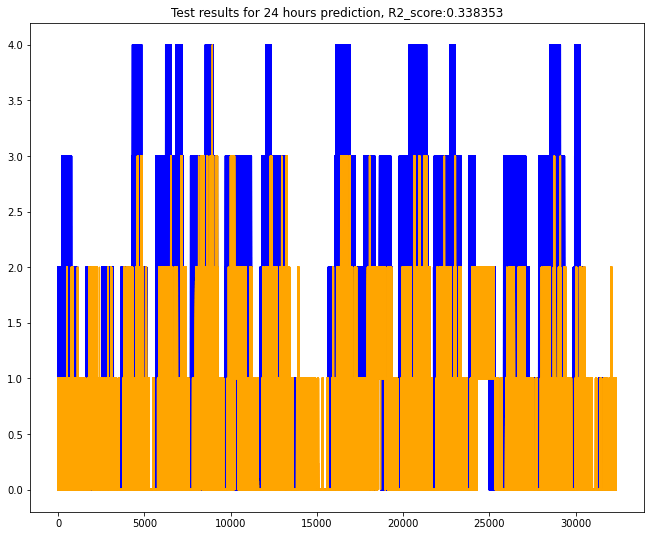

In [ ]:
from sklearn.metrics import r2_score
yhat[yhat <= 0.1] = 0
#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
plt.plot(testY.round(0),label='Orginal',color = 'blue')
plt.plot(yhat.round(0),label='Predicted',color = 'Orange')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY[5000:25000],yhat[5000:25000]))
plt.show()
#plt.legend(loc='best')


Testing CNN Model

In [ ]:
X_train_series = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
X_valid_series = testX.reshape((testX.shape[0], testX.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (80000, 292, 1)
Validation set shape (22355, 292, 1)


In [ ]:
X_train_series.shape[0], X_train_series.shape[1]

(80000, 292)

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='sigmoid', input_shape=(12*24+4,1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='sigmoid'))
model_cnn.add(Dense(288))

model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 291, 64)           192       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 145, 64)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 9280)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                92810     
_________________________________________________________________
dense_29 (Dense)             (None, 288)               3168      
Total params: 96,170
Trainable params: 96,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:


cnn_history = model_cnn.fit(X_train_series, trainY, validation_data=(X_valid_series, testY), epochs=epochs, verbose=2)



Epoch 1/10
2188/2188 - 25s - loss: 0.6735 - val_loss: 0.7805
Epoch 2/10
2188/2188 - 24s - loss: 0.6723 - val_loss: 0.7817
Epoch 3/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7850
Epoch 4/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7758
Epoch 5/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7785
Epoch 6/10
2188/2188 - 25s - loss: 0.6723 - val_loss: 0.7760
Epoch 7/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7783
Epoch 8/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7792
Epoch 9/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7807
Epoch 10/10
2188/2188 - 24s - loss: 0.6722 - val_loss: 0.7789


In [ ]:
ypred = model_cnn.predict(X_valid_series)
ypred

array([[0.47147566, 0.47649178, 0.47854772, ..., 0.5082685 , 0.5025856 ,
        0.5089402 ],
       [0.47147566, 0.47649178, 0.47854772, ..., 0.5082685 , 0.5025856 ,
        0.5089402 ],
       [0.47147566, 0.47649178, 0.47854772, ..., 0.5082685 , 0.5025856 ,
        0.5089402 ],
       ...,
       [0.47147566, 0.47649178, 0.4785477 , ..., 0.5082685 , 0.5025856 ,
        0.5089402 ],
       [0.47147566, 0.47649178, 0.4785477 , ..., 0.5082685 , 0.5025856 ,
        0.5089402 ],
       [0.47147566, 0.47649178, 0.4785477 , ..., 0.5082685 , 0.5025856 ,
        0.5089402 ]], dtype=float32)

-0.022146097287801467


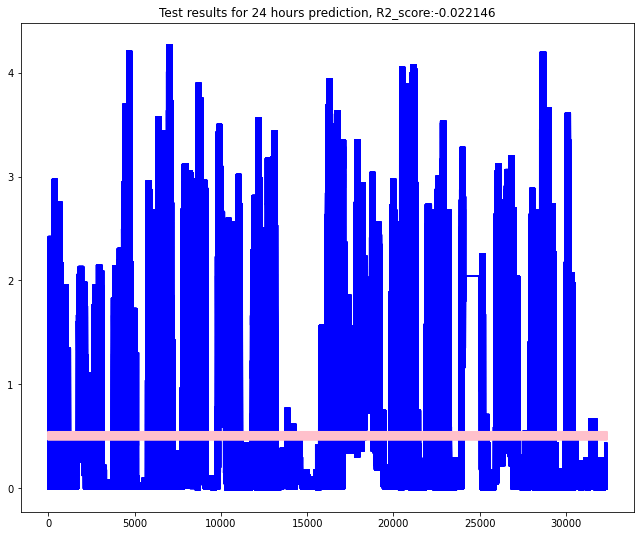

In [ ]:
plt.figure(figsize=(11,9))
plt.plot(testY,label='Orginal',color ="blue")
plt.plot(ypred,label='Predicted',color="pink")
#plt.legend(loc='best')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY,ypred))
print(r2_score(testY,ypred))

In [ ]:
from sklearn.metrics import r2_score
ypred = model_cnn.predict(X_valid_series)
#ypred=ypred.reshape((testY.shape[0]))
for k in range(0,len(ypred)):
  for j in range(0,len(ypred[k])):
    if ypred[k][j]<0:
      ypred[k][j]=0
plt.figure(figsize=(11,9))
plt.plot(testY,label='Orginal',color = 'blue')
plt.plot(ypred,label='Predicted',color = 'Orange')
#plt.legend(loc='best')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY,ypred))
print(r2_score(testY,ypred))

In [ ]:
plt.plot(testY[0],label='Orginal')
plt.plot(ypred[0],label='Predicted')
plt.show()
plt.plot(testY[1500],label='Orginal')
plt.plot(ypred[1500],label='Predicted')
plt.show()

Testing CNN-LSTM model

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (80000, 2, 146, 1)
Validation set shape (22355, 2, 146, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(12*24))
model_cnn_lstm.compile(loss='mse', optimizer="adam")

In [ ]:


cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, trainY, validation_data=(X_valid_series_sub, testY), epochs=10, verbose=2)



Epoch 1/10
2500/2500 - 65s - loss: 0.4942 - val_loss: 0.5930
Epoch 2/10
2500/2500 - 64s - loss: 0.4559 - val_loss: 0.5902
Epoch 3/10
2500/2500 - 72s - loss: 0.5509 - val_loss: 0.5926
Epoch 4/10
2500/2500 - 64s - loss: 0.4468 - val_loss: 0.5716
Epoch 5/10
2500/2500 - 64s - loss: 0.4213 - val_loss: 0.5689
Epoch 6/10
2500/2500 - 64s - loss: 0.4117 - val_loss: 0.6060
Epoch 7/10
2500/2500 - 65s - loss: 0.4048 - val_loss: 0.6034
Epoch 8/10
2500/2500 - 64s - loss: 0.4049 - val_loss: 0.6147
Epoch 9/10
2500/2500 - 64s - loss: 0.4000 - val_loss: 0.6323
Epoch 10/10
2500/2500 - 64s - loss: 0.3847 - val_loss: 0.6052


0.20509668258420838


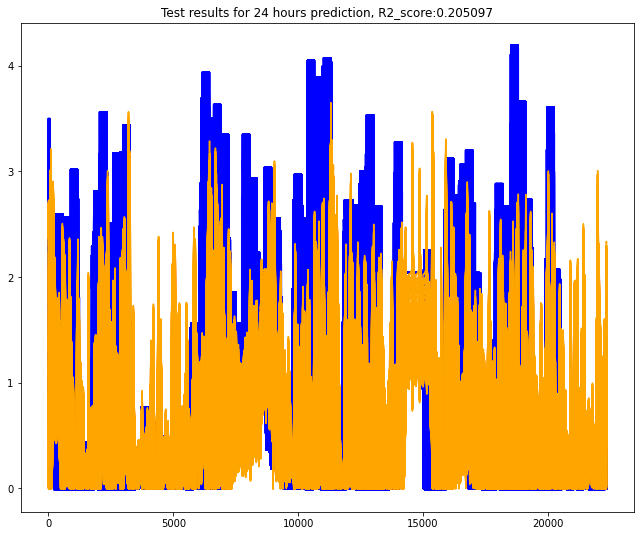

In [ ]:
from sklearn.metrics import r2_score
ypred = model_cnn_lstm.predict(X_valid_series_sub)

for k in range(0,len(ypred)):
  for j in range(0,len(ypred[k])):
    if ypred[k][j]<0:
      ypred[k][j]=0

#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
plt.plot(testY,label='Orginal',color='blue')
plt.plot(ypred,label='Predicted',color='orange')
#plt.legend(loc='best')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY,ypred))
print(r2_score(testY,ypred))

Testing with LSTM

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])
print(trainX.shape)
print(testX.shape)

(70000, 1, 292)
(32355, 1, 292)


In [ ]:
trainX.shape[1],trainX.shape[2]

(1, 292)

In [ ]:
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
model.add(Dense(12*24))
model.compile(loss="mae",optimizer="adam")

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                68600     
_________________________________________________________________
dense_33 (Dense)             (None, 288)               14688     
Total params: 83,288
Trainable params: 83,288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=10,verbose=2,callbacks=[stop_noimprovement],shuffle=False)

Epoch 1/10
2188/2188 - 9s - loss: 0.4806 - val_loss: 0.6574
Epoch 2/10
2188/2188 - 7s - loss: 0.4760 - val_loss: 0.6545
Epoch 3/10
2188/2188 - 7s - loss: 0.4750 - val_loss: 0.6741
Epoch 4/10
2188/2188 - 7s - loss: 0.4740 - val_loss: 0.6653
Epoch 5/10
2188/2188 - 7s - loss: 0.4719 - val_loss: 0.6701
Epoch 6/10
2188/2188 - 7s - loss: 0.4715 - val_loss: 0.6648
Epoch 7/10
2188/2188 - 7s - loss: 0.4711 - val_loss: 0.6609
Epoch 8/10
2188/2188 - 7s - loss: 0.4702 - val_loss: 0.6624
Epoch 9/10
2188/2188 - 7s - loss: 0.4704 - val_loss: 0.6670
Epoch 10/10
2188/2188 - 7s - loss: 0.4702 - val_loss: 0.6639


-0.028796470996991896


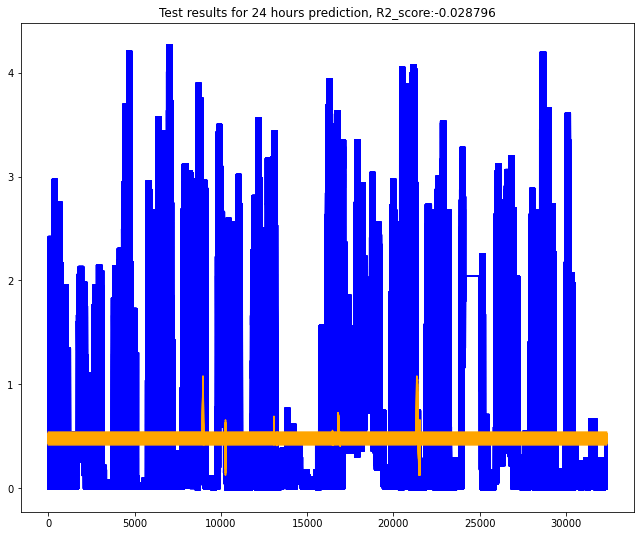

In [ ]:
from sklearn.metrics import r2_score
ypred = model.predict(testX)
#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
for k in range(0,len(ypred)):
  for j in range(0,len(ypred[k])):
    if ypred[k][j]<0:
      ypred[k][j]=0
plt.plot(testY,label='Orginal',color = 'Blue')
plt.plot(ypred,label='Predicted',color='Orange')
#plt.legend(loc='best')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY,ypred))
print(r2_score(testY,ypred))

Testing XGB Regressor with different forecast horizon models

In [ ]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['label'].shift(i+1)

    return df

In [ ]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
        
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X



In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('label%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('label%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('label%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = time
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
     
    return agg

In [ ]:
data2=data[['label']]

#print(data.iloc[:,0])
#labelEncoder = LabelEncoder()
#data.iloc[:,0] = labelEncoder.fit_transform(data.iloc[:,0])
values = data2.values
print(values.shape)
values = values.astype('float32')

(102930, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,12*17,12*17)
reframed

,label1(t-204),label1(t-203),label1(t-202),label1(t-201),label1(t-200),label1(t-199),label1(t-198),label1(t-197),label1(t-196),label1(t-195),label1(t-194),label1(t-193),label1(t-192),label1(t-191),label1(t-190),label1(t-189),label1(t-188),label1(t-187),label1(t-186),label1(t-185),label1(t-184),label1(t-183),label1(t-182),label1(t-181),label1(t-180),label1(t-179),label1(t-178),label1(t-177),label1(t-176),label1(t-175),label1(t-174),label1(t-173),label1(t-172),label1(t-171),label1(t-170),label1(t-169),label1(t-168),label1(t-167),label1(t-166),label1(t-165),...,label1(t+164),label1(t+165),label1(t+166),label1(t+167),label1(t+168),label1(t+169),label1(t+170),label1(t+171),label1(t+172),label1(t+173),label1(t+174),label1(t+175),label1(t+176),label1(t+177),label1(t+178),label1(t+179),label1(t+180),label1(t+181),label1(t+182),label1(t+183),label1(t+184),label1(t+185),label1(t+186),label1(t+187),label1(t+188),label1(t+189),label1(t+190),label1(t+191),label1(t+192),label1(t+193),label1(t+194),label1(t+195),label1(t+196),label1(t+197),label1(t+198),label1(t+199),label1(t+200),label1(t+201),label1(t+202),label1(t+203)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-07 08:00:00,0.333945,0.246904,0.248968,0.189060,0.156078,0.150573,0.140940,0.154702,0.155390,0.139908,0.145069,0.179816,0.173280,0.326537,0.479743,0.520628,0.575459,0.551032,0.559977,0.535550,0.450229,0.416161,0.420844,0.448509,0.419514,0.414651,0.423252,0.539335,0.538459,0.536927,0.406339,0.422266,0.419468,0.416161,0.404275,0.542587,0.553252,0.404275,0.558413,0.581463,...,0.140940,0.140940,0.139908,0.146789,0.139908,0.143349,0.140940,0.146789,0.143349,0.139908,0.140940,0.154702,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.140940,0.140940,0.161583,0.140940,0.140940,0.140940,0.140940,0.143349,0.140940,0.143349,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908
2015-01-07 08:05:00,0.246904,0.248968,0.189060,0.156078,0.150573,0.140940,0.154702,0.155390,0.139908,0.145069,0.179816,0.173280,0.326537,0.479743,0.520628,0.575459,0.551032,0.559977,0.535550,0.450229,0.416161,0.420844,0.448509,0.419514,0.414651,0.423252,0.539335,0.538459,0.536927,0.406339,0.422266,0.419468,0.416161,0.404275,0.542587,0.553252,0.404275,0.558413,0.581463,0.607110,...,0.140940,0.139908,0.146789,0.139908,0.143349,0.140940,0.146789,0.143349,0.139908,0.140940,0.154702,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.140940,0.140940,0.161583,0.140940,0.140940,0.140940,0.140940,0.143349,0.140940,0.143349,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908
2015-01-07 08:10:00,0.248968,0.189060,0.156078,0.150573,0.140940,0.154702,0.155390,0.139908,0.145069,0.179816,0.173280,0.326537,0.479743,0.520628,0.575459,0.551032,0.559977,0.535550,0.450229,0.416161,0.420844,0.448509,0.419514,0.414651,0.423252,0.539335,0.538459,0.536927,0.406339,0.422266,0.419468,0.416161,0.404275,0.542587,0.553252,0.404275,0.558413,0.581463,0.607110,0.613991,...,0.139908,0.146789,0.139908,0.143349,0.140940,0.146789,0.143349,0.139908,0.140940,0.154702,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.140940,0.140940,0.161583,0.140940,0.140940,0.140940,0.140940,0.143349,0.140940,0.143349,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.140940
2015-01-07 08:15:00,0.189060,0.156078,0.150573,0.140940,0.154702,0.155390,0.139908,0.145069,0.179816,0.173280,0.326537,0.479743,0.520628,0.575459,0.551032,0.559977,0.535550,0.450229,0.416161,0.420844,0.448509,0.419514,0.414651,0.423252,0.539335,0.538459,0.536927,0.406339,0.422266,0.419468,0.416161,0.404275,0.542587,0.553252,0.404275,0.558413,0.581463,0.607110,0.613991,0.598853,...,0.146789,0.139908,0.143349,0.140940,0.146789,0.143349,0.139908,0.140940,0.154702,0.139908,0.139908,0.139908,0.139908,0.139908,0.139908,0.140940,0.140940,0.161583,0.140940,0.

In [ ]:
lag_count = 0
df = data
df2 = series_to_supervised(scaled,17*12,17*12)
df2.insert(0,'hour',df2.index.hour)
df2.insert(0,'dayofweek',df2.index.dayofweek)
df2.insert(0,'dayofmonth',df2.index.day)

df2

In [ ]:
import lightgbm as lgb

In [ ]:
values1 = df2.values

train = values1[:40000]
test = values1[40000:]

reg = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=1000)

y_pred = []
print(len(train[0,12*17+3:]))
for k in range (103,104):
  print(k)
  trainX,trainY = train[:,3:-17*12],train[:,12*17+3+k:12*17+3+k+1]
  testX,testY = test[:,3:-17*12],test[:,12*17+3+k:12*17+3+k+1]

  reg.fit(trainX, trainY,verbose=True) # Change verbose to True if you want to see it train

  y_pred.append(reg.predict(testX))


In [ ]:
plt.figure(figsize=(20,9))
for k in range(0,len(y_pred[0])):
  if y_pred[0][k]<0:
      y_pred[0][k]=0
plt.plot(y_pred[0])

plt.plot(df2["label1(t+103)"][40000:].values)



In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_pred[0][0:10000],df2["label1(t+103)"][40000:][0:10000].values))

In [ ]:
y_new_inverse = MinMaxScaler().inverse_transform(y_pred[0])

In [ ]:
trainX.shape

In [ ]:
testX.shape

In [ ]:
trainY.shape

In [ ]:
testY.shape

In [ ]:
import lightgbm as lgb

In [ ]:

reg = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=1000)
reg.fit(trainX, trainY,verbose=True) # Change verbose to True if you want to see it train


In [ ]:
y_pred=reg.predict(testX)

In [ ]:
plt.plot(y_pred)

In [ ]:
X_test.shape

In [ ]:
y_pred = reg.predict(X_test)



In [ ]:
plt.plot(y_pred)

In [ ]:
plt.plot(y_test)